# 04b Multiple Linear regression model trained on good IMD regions 

> k-fold cross validation of regression model choice   

In [64]:
#|default_exp core.04_regression_model

In [65]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02b_LAD_and_GP_intersections.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02c_GP_doctors_per_LAD.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [66]:
#|hide
from nbdev.showdoc import show_doc

In [67]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [68]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
import itertools

import scipy.stats as st

---

This model looks at automating the choice of parameters and the choice of training dataset using k-fold cross validation. 

In [69]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [70]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.142036
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.278995
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.129934
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.497021
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.113788


These are the covariates I'm interested in - each is calculated as a percentage of the total population of the region. 
* Age (% people over 65) `over_65_pc`
* Gender (% people female) `female_pc`
* Educational attainment (% people with A-level or higher education) `ALevel_plus_pc`
* Ethnicity (% people who are white British) `white_pc`
* Comorbidities (% people with various dementia comorbidities)
    - Hypertension `HYP_afflicted_pc`
    - Diabetes `DM_afflicted_pc`
    - Stroke `STIA_afflicted_pc`
* Density of GPs (total number of GPs/ pop) `GP_LAD_pc`

In [71]:
# Potential covariates 
covar_opt = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc', 
             'GP_LAD_pc']

How do we understand these residuals? Might be a good idea to look at the areas which we would expect to have high rates of diagnosis - for example if we look at top 50 areas accoridng to the IMD (or ADI). 

In [72]:
df_IMD = pd.read_excel(const.data_path+'/IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx', sheet_name='IMD')

In [73]:
# the 50 least deprived LADs according to the IMD
least_50_IMD = list(df_IMD[df_IMD['IMD - Rank of average rank ']>317-60]['Local Authority District name (2019)'])

# check the overlap between regions in IMD and ADI 
df_dem_topIMD = df_dem_plus[df_dem_plus['area_name'].isin(least_50_IMD)].copy()

list_45 = list(df_dem_topIMD['area_name'])
list(set(least_50_IMD).difference(list_45))

['Aylesbury Vale',
 'South Bucks',
 'South Northamptonshire',
 'Wycombe',
 'Chiltern']

In [74]:
print(least_50_IMD)

['York', 'Rutland', 'Bath and North East Somerset', 'South Gloucestershire', 'Bracknell Forest', 'West Berkshire', 'Windsor and Maidenhead', 'Wokingham', 'Central Bedfordshire', 'Aylesbury Vale', 'Chiltern', 'South Bucks', 'Wycombe', 'East Cambridgeshire', 'South Cambridgeshire', 'Derbyshire Dales', 'Brentwood', 'Chelmsford', 'Rochford', 'Uttlesford', 'Cotswold', 'Stroud', 'Tewkesbury', 'East Hampshire', 'Eastleigh', 'Fareham', 'Hart', 'Test Valley', 'Winchester', 'North Hertfordshire', 'Three Rivers', 'Tunbridge Wells', 'Ribble Valley', 'Blaby', 'Harborough', 'North Kesteven', 'South Northamptonshire', 'Harrogate', 'Rushcliffe', 'South Oxfordshire', 'Vale of White Horse', 'West Oxfordshire', 'Elmbridge', 'Epsom and Ewell', 'Guildford', 'Mole Valley', 'Reigate and Banstead', 'Surrey Heath', 'Tandridge', 'Waverley', 'Woking', 'Stratford-on-Avon', 'Warwick', 'Horsham', 'Mid Sussex', 'Bromsgrove', 'St Albans', 'East Hertfordshire', 'Kingston upon Thames', 'Richmond upon Thames']


2020, the former District Council areas of Aylesbury Vale, Chiltern, South Bucks and Wycombe and Buckinghamshire County Council came together to form a single Unitary Authority, Buckinghamshire Council.

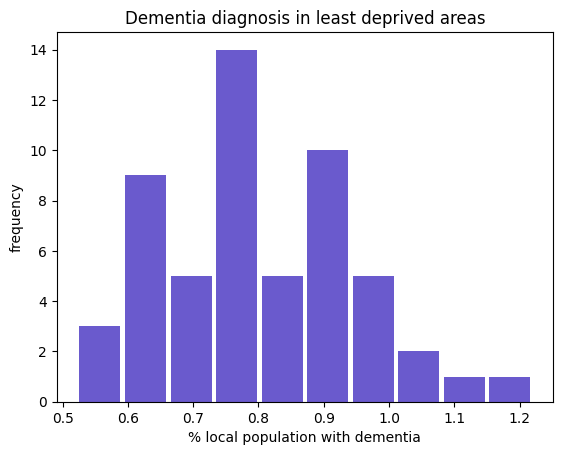

In [75]:
# dementia diagnosis in least deprived areas 
dem_diag_least_IMD = df_dem_topIMD['DEM_afflicted_pc']

# histogram plot of frequency of diagnosis % 
plt.hist(dem_diag_least_IMD, color='slateblue', rwidth=0.9)
plt.title('Dementia diagnosis in least deprived areas')
plt.xlabel('% local population with dementia')
plt.ylabel('frequency')
plt.show()

## All possible covariates 
What happens if I include all possible covariates?

In [76]:
print(covar_opt)

['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']


In [77]:
# Linear regression using sklearn 

x_IMD_train = df_dem_topIMD[covar_opt].values.reshape(-1,len(covar_opt))
y_IMD_train = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y_test_all = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_IMD_train, y_IMD_train)
y_pred_all = regr.predict(x_test_all)

In [78]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.31293386567688863
-------- 
 coefficients of independent variables 
 
over_65_pc:0.018826502157264044 

female_pc:0.007082685397652472 

ALevel_plus_pc:-0.0065006226140778625 

white_pc:-0.00494408783267441 

HYP_afflicted_pc:0.005088706983298675 

DM_afflicted_pc:-0.020680697151659856 

STIA_afflicted_pc:0.22470244482263949 

GP_LAD_pc:-0.15968462545378456 



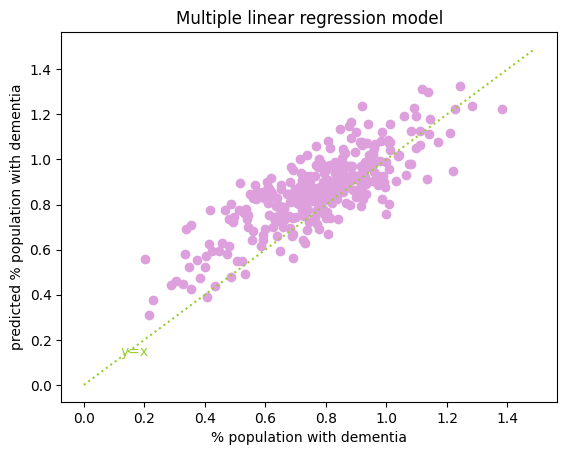

In [79]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y_test_all, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.12, 0.13, r'y=x', fontsize=10, color='yellowgreen')
#plt.text(0.2, 0.12, r'potential underdiagnosis', fontsize=10)
plt.show()

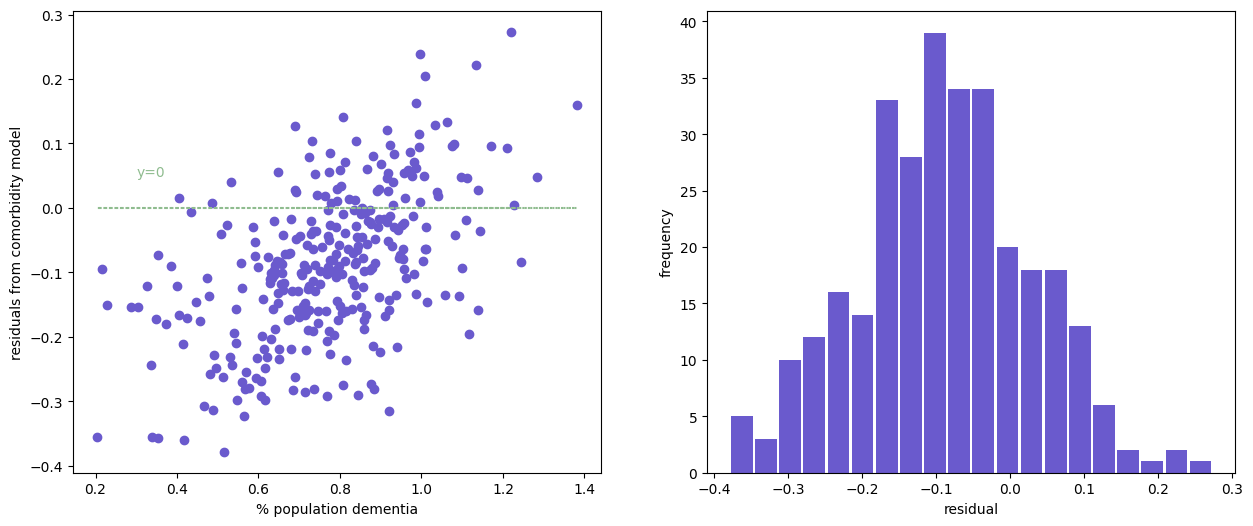

In [80]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals = (y_test_all-y_pred_all)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, residuals, color='slateblue')
plt.plot(y_test_all, np.zeros(len(y_test_all)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

### Save the results of the regression model to a .csv 

In [81]:
# add columns of results to the dataframe 
df_dem_plus['IMD_reg_model_residuals'] = residuals
df_dem_plus['IMD_reg_model_pred'] = y_pred_all

# save the dataframe 
df_dem_plus.to_csv(const.output_path+'/IMD_test_set_reg_model/IMD_reg_model_results.csv')

## Look at IMD rank of areas with large residuals

In [18]:
# Areas residuals 

# look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
resid_gap_area = df_dem_plus[residuals<-0.3]['area_name']
print(resid_gap_area)
#[x for x in list(resid_gap_area)]

21     Barking and Dagenham
73                   Slough
75                 Redditch
90               Birmingham
132                  Ealing
197                Sandwell
284                  Newham
286                Torridge
290                   Brent
Name: area_name, dtype: object


In [19]:
residuals[40]

array([-0.27550675])

In [20]:
df_dem_plus[df_dem_plus['area_name']=='South Hams']

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
40,E07000044,South Hams,74072,597.62437,12201.179619,4036.440908,1928.689732,42560.0,46217.5554,42993.9842,...,94.2,0.806815,57.457609,34.069395,62.395447,16.472054,5.449348,2.603804,143.377905,0.193566


In [44]:
worst_5_resid = np.argsort(np.array(residuals.reshape(309)))[-15:]
df_dem_plus.iloc[worst_5_resid, :][['area_name']+covar_opt]

,area_name,over_65_pc,female_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc
25,Worthing,27.574793,63.322383,50.175539,85.0,16.385577,6.617740,2.314350,0.129606
289,Lincoln,18.124966,61.697292,54.075785,82.7,11.432470,4.744160,1.545944,0.060688
102,Colchester,21.530152,61.296004,50.439987,80.7,13.583193,4.800804,1.591681,0.111092
10,Southend-on-Sea,23.600073,63.109901,44.333027,81.6,15.104013,5.784186,1.922887,0.147230
159,Rushcliffe,26.156822,61.437173,61.366935,86.1,13.192616,4.785857,1.947610,0.171084
248,Guildford,20.409057,58.736111,61.339131,77.3,11.853822,4.275616,1.304893,0.216969
272,Gosport,25.530861,60.593137,43.336177,92.5,16.899720,7.549057,2.248049,0.096413
119,Harrogate,28.871180,62.810418,57.045926,90.7,15.806634,5.160332,2.240924,0.185737
225,Southampton,16.705164,59.824464,51.816027,68.1,11.039538,5.131145,1.630277,0.165229
29,East Devon,36.652563,63.256897,52.088405,94.2,18.398179,6.787375,2.868139,0.136074


In [45]:
df_IMD[df_IMD['Local Authority District name (2019)'].isin(resid_gap_area)]

NameError: name 'resid_gap_area' is not defined

In [ ]:
df_dem_plus_IMD = pd.merge(df_dem_plus, df_IMD[['IMD - Rank of average rank ', 'Local Authority District name (2019)']], left_on='area_name', right_on='Local Authority District name (2019)')

In [ ]:
df_dem_plus_IMD.drop(columns='Local Authority District name (2019)', inplace=True)

In [ ]:
df_dem_plus_IMD

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,residual,IMD - Rank of average rank
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.142036,0.004348,241
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.278995,0.055570,297
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.129934,0.098166,273
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.497021,0.238217,112
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.113788,-0.162971,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,E07000098,Hertsmere,82921,670.292640,11021.724346,4685.682668,1328.437922,46875.0,56088.1445,51979.7732,...,56.529709,23.255361,67.640458,13.291837,5.650779,1.602052,222.131324,0.267883,-0.010010,224
302,E08000024,Sunderland,228781,1815.593270,39805.733965,15607.611455,5391.466952,94211.0,141179.1277,133107.8801,...,41.179556,24.755926,61.709289,17.399056,6.822075,2.356606,398.125138,0.174020,-0.144676,33
303,E06000050,Cheshire West and Chester,281913,2115.072286,42946.758704,16327.686339,5778.511168,157848.0,182966.3133,174617.3565,...,55.991742,27.061403,64.901694,15.234047,5.791747,2.049750,293.938550,0.104266,-0.118623,183
304,E07000210,Mole Valley,72165,707.782207,10694.196102,3455.860767,1495.801962,42396.0,44954.5255,42642.7851,...,58.748701,28.978935,62.294084,14.819090,4.788832,2.072753,117.926289,0.163412,0.071142,294


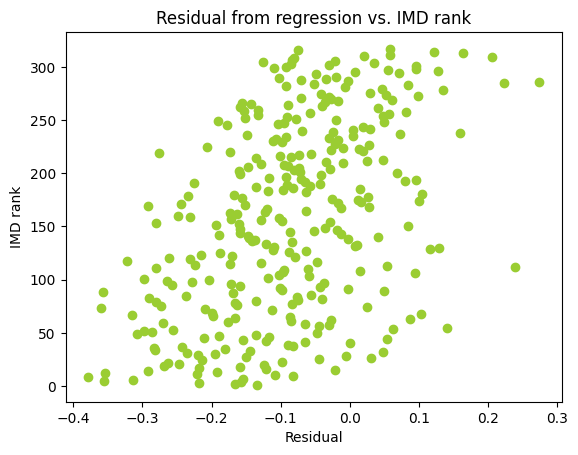

In [ ]:
plt.scatter(df_dem_plus_IMD['residual'], df_dem_plus_IMD['IMD - Rank of average rank '], color='yellowgreen')
plt.xlabel('Residual')
plt.ylabel('IMD rank')
plt.title('Residual from regression vs. IMD rank')
plt.show()

### Ridge regression 

In [ ]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[covar_opt].values.reshape(-1,8)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[covar_opt].values.reshape(-1,8)

regr = linear_model.Ridge(alpha=1)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

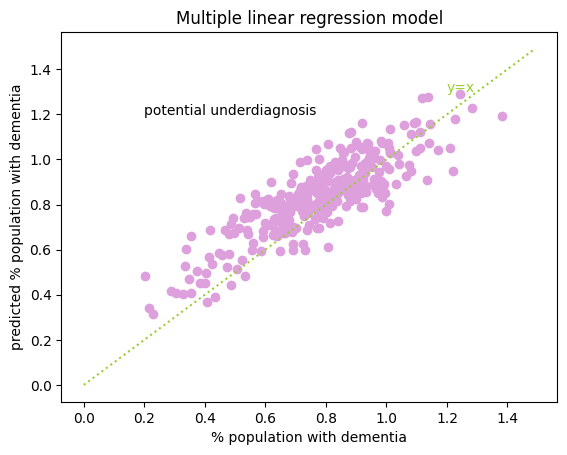

In [ ]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [ ]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.19011864576319404
-------- 
 coefficients of independent variables 
 
over_65_pc:0.021739464197558196 

female_pc:0.004275571054316298 

ALevel_plus_pc:-0.004718078458165609 

white_pc:-0.003163015965931863 

HYP_afflicted_pc:0.01455257622991945 

DM_afflicted_pc:-0.013227272662883894 

STIA_afflicted_pc:0.10717538794687316 

GP_LAD_pc:-0.03761093249805121 



In [ ]:
np.dot(np.array(x_test_all_covar), regr.coef_[0]) + regr.intercept_[0]

array([1.17886359, 0.59595594, 0.78964987, 0.76986408, 0.95762173,
       0.70911729, 0.81637759, 0.85136213, 0.91296714, 0.79118214,
       0.84957569, 0.86125686, 0.89538644, 1.07134832, 0.92390905,
       0.89807301, 1.03349221, 0.7955494 , 0.85074106, 0.88622453,
       0.66897922, 0.60459572, 0.79377745, 0.88324622, 1.03834752,
       0.94881519, 0.80810021, 0.98591356, 0.91534381, 1.19391026,
       0.8591363 , 1.15602532, 0.4416283 , 0.97581682, 0.7967697 ,
       1.13555779, 0.86429784, 0.73977679, 1.04740972, 0.81436875,
       1.06791392, 0.40448764, 0.5530166 , 0.65847168, 0.86103087,
       0.81003879, 0.73667165, 0.94150893, 0.49809005, 0.89589585,
       0.94010101, 0.58067943, 0.71705155, 0.74563542, 0.78570512,
       0.90745938, 1.1655669 , 0.69650188, 0.67415885, 0.99862998,
       0.74218644, 1.03729008, 0.31653912, 1.05160456, 0.8442607 ,
       0.65501077, 0.9536198 , 0.7935345 , 0.82385753, 0.6864783 ,
       0.6834494 , 1.03368386, 0.88454222, 0.68505331, 1.15473

### Lasso regression 

In [ ]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[covar_opt].values.reshape(-1,8)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[covar_opt].values.reshape(-1,8)

regr = linear_model.Lasso(alpha=0.001)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

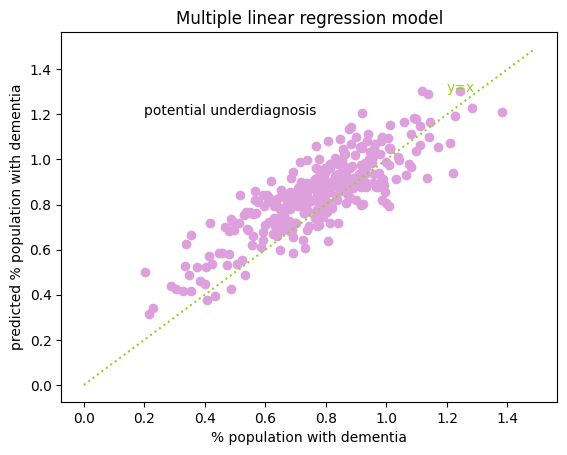

In [ ]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [ ]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[i]} \n')

intercept:0.09231771619329654
-------- 
 coefficients of independent variables 
 
over_65_pc:0.01883902789186213 

female_pc:0.005324509840840281 

ALevel_plus_pc:-0.004366294959799784 

white_pc:-0.0030462972119286043 

HYP_afflicted_pc:0.0074516115914967295 

DM_afflicted_pc:-0.0031765348826858575 

STIA_afflicted_pc:0.17126583697847442 

GP_LAD_pc:-0.0 

